In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T
from PIL import Image
import torch
from sklearn.neighbors import KNeighborsClassifier
from math import sin, cos, pi, asin, acos

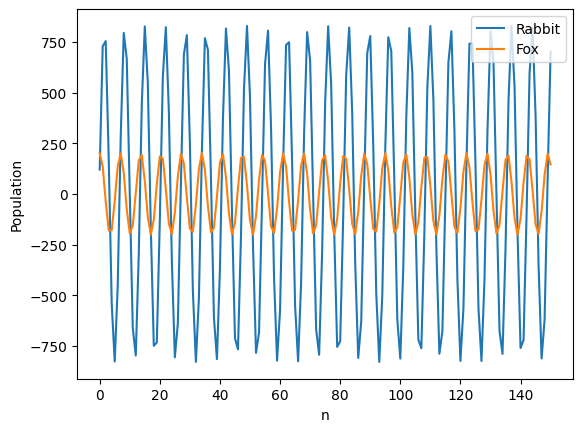

In [61]:
X_0 = np.array([120, 200])

def f(n, X_0):
    A = np.array([[0.4, 3.4], [-0.2, 0.8]])
    return np.dot(np.linalg.matrix_power(A, n), X_0)

n = np.arange(0, 151)
X = np.array([f(i, X_0) for i in n])

plt.plot(n, X[:, 0], label='Rabbit')
plt.plot(n, X[:, 1], label='Fox')
plt.xlabel('n')
plt.ylabel('Population')
plt.legend()
plt.show()

In [62]:
X[-1]

array([     701.58,      145.06])

In [63]:
cycle = asin(0.8) * 150
820 * sin(cycle) + 120 * cos(cycle)

701.5848839284686

In [64]:
20 * sin(cycle) + 200 * cos(cycle)

145.06045225945482

/tmp/ipykernel_13111/913057586.py:3: RuntimeWarning: invalid value encountered in sqrt
  yt = np.sqrt(1 - x**2)
/tmp/ipykernel_13111/913057586.py:4: RuntimeWarning: invalid value encountered in sqrt
  yb = -np.sqrt(1 - x**2)


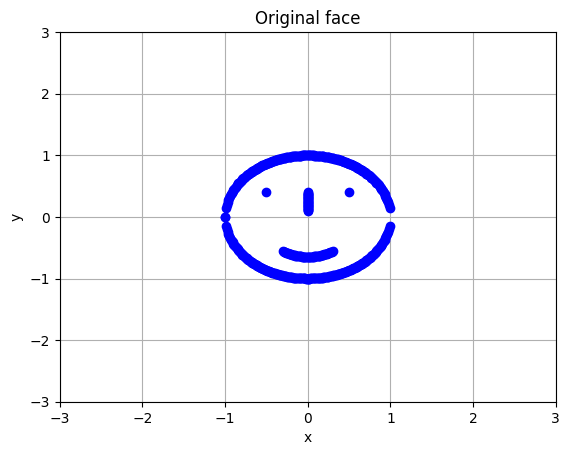

In [ ]:
# Define face geometry
x  = np.arange(-1, 1.01, 0.01)
yt = np.sqrt(1 - x**2)
yb = -np.sqrt(1 - x**2)

xm = np.arange(-0.3, 0.31, 0.01)
ym = -0.1 - np.sqrt(0.3 - xm**2)

yn = np.arange(0.1, 0.401, 0.01)
xn = np.zeros_like(yn)

left_eye  = np.array([-0.5, 0.4])
right_eye = np.array([0.5, 0.4])

def make_face(x, yt, yb, xn, yn, xm, ym, left_eye, right_eye):
    head_top    = np.vstack([x, yt])
    head_bottom = np.vstack([x, yb])
    nose        = np.vstack([xn, yn])
    mouth       = np.vstack([xm, ym])
    eye_left    = left_eye.reshape(2,1)
    eye_right   = right_eye.reshape(2,1)

    return np.hstack([
        head_top,
        np.full((2,1), np.nan),  # break in the plot
        head_bottom,
        np.full((2,1), np.nan),
        nose,
        np.full((2,1), np.nan),
        mouth,
        np.full((2,1), np.nan),
        eye_left,
        np.full((2,1), np.nan),
        eye_right
    ])

face_points = make_face(x, yt, yb, xn, yn, xm, ym, left_eye, right_eye)

T = np.array([[-1, 0],
              [ 0,-1]])

Tface_points = T @ face_points

def plot_face(face_points, title='Original face'):
    plt.plot(face_points[0, :], face_points[1, :], 'b', marker='o')
    plt.axis([-3, 3, -3, 3])
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

plot_face(face_points)

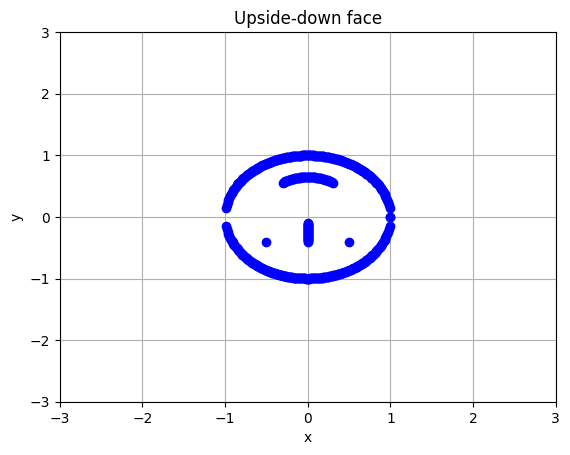

In [66]:
plot_face(Tface_points, title='Upside-down face')

a

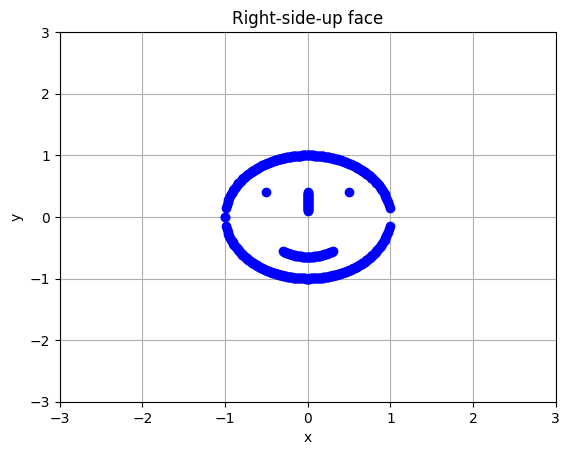

In [67]:
Tface_points = T @ Tface_points
plot_face(Tface_points, title='Right-side-up face')

b

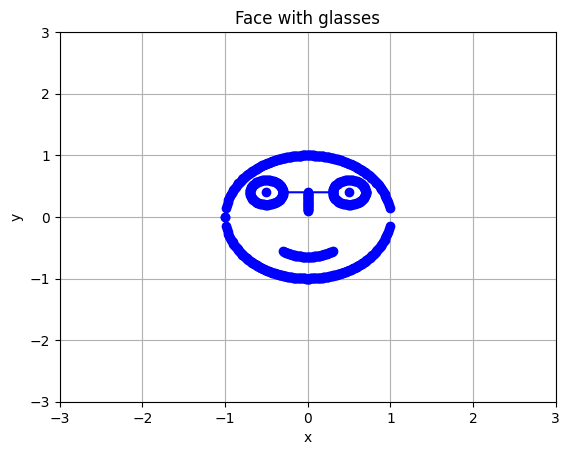

In [68]:
def make_glasses():
    theta = np.linspace(0, 2*np.pi, 100)

    # Left circle, centered at (-0.5, 0.4)
    xg1 = 0.2*np.cos(theta) - 0.5
    yg1 = 0.2*np.sin(theta) + 0.4
    left_circle = np.vstack([xg1, yg1])

    # Right circle, centered at ( 0.5, 0.4)
    xg2 = 0.2*np.cos(theta) + 0.5
    yg2 = 0.2*np.sin(theta) + 0.4
    right_circle = np.vstack([xg2, yg2])

    # Bridge between the two circles
    xb = np.linspace(-0.3, 0.3, 2)
    yb = 0.4 * np.ones_like(xb)
    bridge = np.vstack([xb, yb])

    # Combine them, inserting NaNs to separate lines
    glasses_points = np.hstack([
        left_circle,
        np.full((2,1), np.nan),
        right_circle,
        np.full((2,1), np.nan),
        bridge
    ])
    return glasses_points

glasses_points = make_glasses()

face_with_glasses = np.hstack([
    face_points,
    np.full((2,1), np.nan),  # break so we don't connect face to glasses
    glasses_points
])

plot_face(face_with_glasses, title='Face with glasses')

c

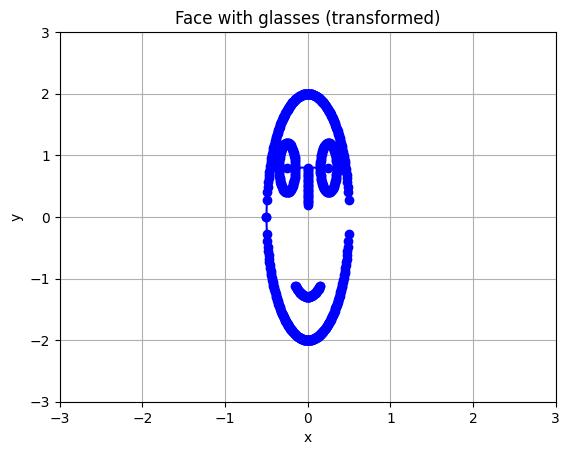

In [69]:
T = np.array([[0.5, 0],
              [0, 2]])

face_with_glasses = T @ face_with_glasses
plot_face(face_with_glasses, title='Face with glasses (transformed)')

d

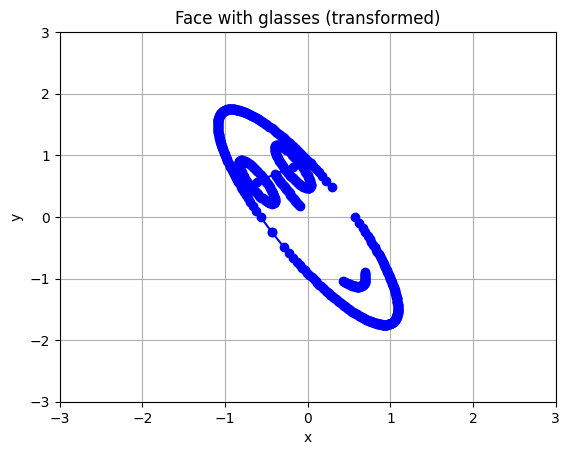

In [70]:
theta = 30 * np.pi / 180
T = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
face_with_glasses = T @ face_with_glasses
plot_face(face_with_glasses, title='Face with glasses (transformed)')

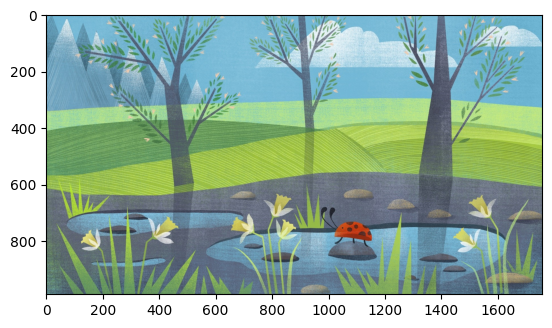

In [7]:
def load_image(path):
    # Read image in BGR
    img_bgr = cv2.imread(path)
    # Convert to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

image_paths = ['spring.jpg', 'fall.jpg', 'summer.jpg', 'winter.jpg']
images = [load_image(path) for path in image_paths]
plt.imshow(images[0])

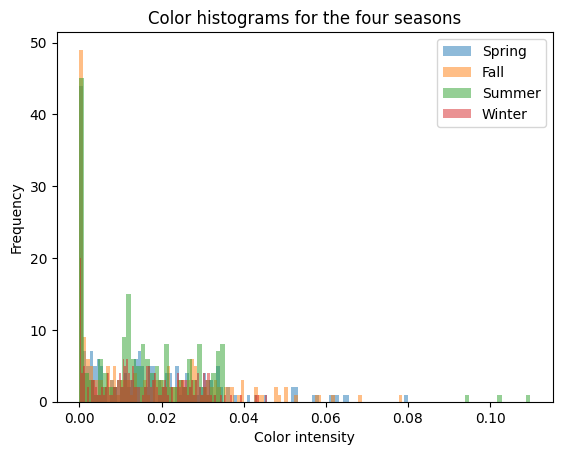

In [55]:
def color_histogram(img_rgb, bins=32):
    hist_r = cv2.calcHist([img_rgb], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([img_rgb], [1], None, [bins], [0, 256])
    hist_b = cv2.calcHist([img_rgb], [2], None, [bins], [0, 256])
    
    # Normalize so that histogram sum = 1
    hist_r /= (img_rgb.shape[0] * img_rgb.shape[1])
    hist_g /= (img_rgb.shape[0] * img_rgb.shape[1])
    hist_b /= (img_rgb.shape[0] * img_rgb.shape[1])
    
    # Flatten and concatenate
    return np.concatenate([hist_r.flatten(), 
                           hist_g.flatten(), 
                           hist_b.flatten()])

for img in images:
    plt.hist(color_histogram(img, bins=64), bins=96, alpha=0.5)
plt.xlabel('Color intensity')
plt.ylabel('Frequency')
plt.title('Color histograms for the four seasons')
seasons = ['Spring', 'Fall', 'Summer', 'Winter']
plt.legend(seasons)
plt.show()

In [59]:
# Extract features for all images
features = [color_histogram(img, bins=32) for img in images]
features = np.array(features)

labels = np.array([0, 1, 2, 3])

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(features, labels)

predictions = knn.predict(features)

print("Labels:     ", labels)
print("Predictions:", predictions)

Labels:      [0 1 2 3]
Predictions: [0 1 2 3]


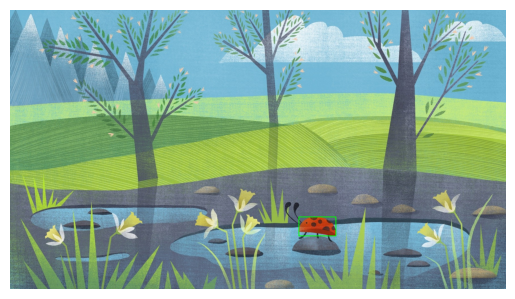

Detected bounding box: (1023, 734, 131, 67)


In [ ]:
def find_red_object(image_path):
    # Read image (as BGR by default in OpenCV)
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Could not load image {image_path}")
    
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Define red color ranges
    # Red in HSV can appear in two “clusters” around hue=0 and hue=180. 
    lower_red1 = np.array([0,   100, 100])   # hue=0, sat=100, val=100
    upper_red1 = np.array([10,  255, 255])
    lower_red2 = np.array([170, 100, 100])   # hue=170
    upper_red2 = np.array([180, 255, 255])

    # 3) Threshold the HSV image to get red regions
    mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    
    # Combine two masks
    mask = cv2.bitwise_or(mask1, mask2)

    # Clean up noise via morphological operations
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours found, return
    if not contours:
        print("No red object found!")
        return

    # Pick the largest contour (as a guess for the ladybug)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding box for that contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Draw bounding box on the original image
    cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Show the result
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    return (x, y, w, h), img_rgb

bbox, annotated_image = find_red_object("spring.jpg")
print("Detected bounding box:", bbox)

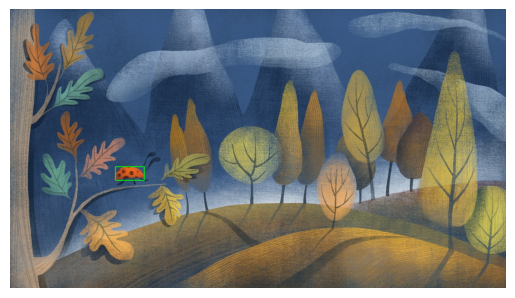

Detected bounding box: (373, 558, 102, 48)


In [35]:
bbox, annotated_image = find_red_object("fall.jpg")
print("Detected bounding box:", bbox)

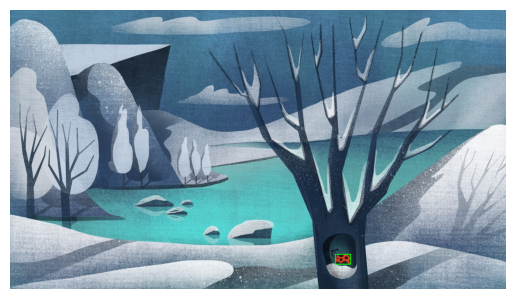

Detected bounding box: (1152, 866, 54, 35)


In [37]:
bbox, annotated_image = find_red_object("winter.jpg")
print("Detected bounding box:", bbox)

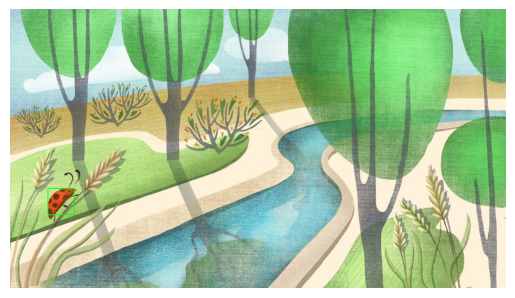

Detected bounding box: (134, 635, 93, 93)


In [36]:
bbox, annotated_image = find_red_object("summer.jpg")
print("Detected bounding box:", bbox)